# Generating Bounding Boxes from Audio Annotations

This notebook aims to generate a new column in a CSV file containing the normalized coordinates of the bounding boxes based on audio annotations. Audio annotations are represented in a pandas DataFrame containing information about the time, frequency, and associated species for each annotation. The normalized coordinates of the bounding boxes will be calculated in relation to the dimensions of the corresponding spectrogram image.

**Steps:**

1. Load the CSV file containing the audio annotations.
2. Define the function to calculate the normalized coordinates of the bounding boxes.
3. Iterate over the rows of the annotations DataFrame to calculate the coordinates and add them to the DataFrame.
4. Save the modified DataFrame to a new CSV file.

**Requirements:**

- The CSV file of annotations must contain the following columns: 'start_time', 'end_time', 'low_frequency', 'high_frequency', 'specie', 'path' (path to the corresponding image).


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ROOT_PATH = "../../../desarrollo/"

# Path to the CSV file of audio annotations
csv_file = ROOT_PATH + "Data/Annotations/audio_annotations.csv"

In [3]:
# Load the CSV file into a pandas DataFrame
annotations_df = pd.read_csv(csv_file)

# Display the first few rows of the DataFrame to verify the correct loading of data
annotations_df.head()

,path,recorder,date,time,audio_duration,start_time,end_time,low_frequency,high_frequency,specie
0,AM1/2023_05_15/AM1_20230515_060000.WAV,AM1,2023/05/15,06:00:00,00:01:00,0.000000,2.957143,6924.452637,12307.774414,quiroptera
1,AM1/2023_05_15/AM1_20230515_060000.WAV,AM1,2023/05/15,06:00:00,00:01:00,0.865714,1.800000,3227.233154,5087.216797,unknown
2,AM1/2023_05_15/AM1_20230515_060000.WAV,AM1,2023/05/15,06:00:00,00:01:00,4.174286,16.088571,7.065833,9697.166992,abiotic noise
3,AM1/2023_05_15/AM1_20230515_060000.WAV,AM1,2023/05/15,06:00:00,00:01:00,15.960000,16.894286,3438.405056,5453.471119,unknown
4,AM1/2023_05_15/AM1_20230515_060000.WAV,AM1,2023/05/15,06:00:00,00:01:00,23.434286,25.285714,2780.975830,5137.292969,alaudidae


In [18]:
IMAGE_ROOT_PATH = image_path = ROOT_PATH + "Data/Dataset/Images/"
image_path = ROOT_PATH + "Data/Dataset/Images/" + annotations_df["path"][0].replace(".WAV", ".jpg")
img = plt.imread(image_path)
WIDTH = img.shape[1]
HEIGHT = img.shape[0]

MAX_FREQUENCY = 16000

In [55]:
print("Image dimensions: ", WIDTH, "x", HEIGHT)

Image dimensions:  930 x 462


In [13]:
# Function to convert HH:MM:SS format to seconds
def hms_to_seconds(hms):
    if isinstance(hms, str):
        time_parts = hms.split(':')
        if len(time_parts) == 3:
            hours, minutes, seconds = map(int, time_parts)
            total_seconds = hours * 3600 + minutes * 60 + seconds
            return total_seconds
    elif isinstance(hms, float):
        return float(hms)
    return None

In [59]:
# Function to calculate the normalized bounding box coordinates
def calculate_bbox(row):
    audio_duration = row['audio_duration']
    audio_duration = hms_to_seconds(audio_duration)

    # Get the coordinates of the annotations
    start_time = row['start_time']
    end_time = row['end_time']
    low_frequency = row['low_frequency']
    high_frequency = row['high_frequency']

    if start_time is not None and end_time is not None:
        start = int(start_time / audio_duration * WIDTH)
        end = int(end_time / audio_duration * WIDTH)

    # Set maximum frequency to 16000 Hz if high_frequency is -1 (unknown)
    if high_frequency == -1:
        high_frequency = MAX_FREQUENCY

    if low_frequency <= 1:
        bottom = 1
    else:
        bottom = float(np.log(low_frequency) / np.log(MAX_FREQUENCY) * img.shape[0])

    if high_frequency == MAX_FREQUENCY:
        top = MAX_FREQUENCY
    else:
        top = float(np.log(high_frequency) / np.log(MAX_FREQUENCY) * img.shape[0])

    # Invert the y-coordinates
    bottom, top = img.shape[0] - top, img.shape[0] - bottom

    # print(start, end, bottom, top)
    
    # Calculate the normalized coordinates of the bounding box center and size
    x_center = (start + end) / 2
    y_center = (top + bottom) / 2
    width = (end - start)
    height = (top - bottom)

    # Normalize x_center and y_center
    x_center /= WIDTH
    y_center /= HEIGHT
    width /= WIDTH
    height /= HEIGHT
    
    # Return the coordinates in list format
    return [x_center, y_center, width, height]

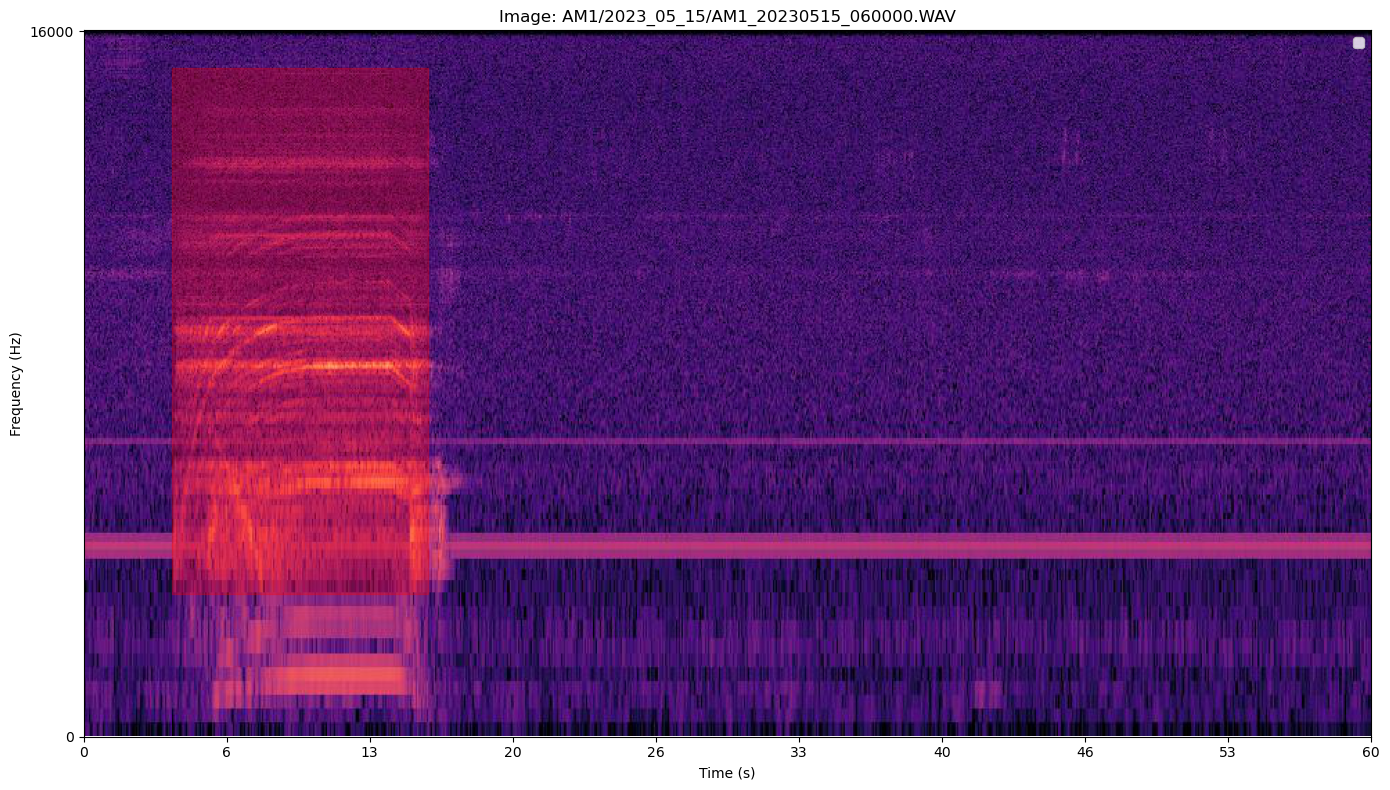

In [61]:
def plot_image_with_yolo_bbox(row, bbox):
    image_path = IMAGE_ROOT_PATH + row["path"].replace(".WAV", ".jpg")

    # Load the audio image
    img = plt.imread(image_path)
    
    # Create a figure and axis for the image
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Display the audio image
    ax.imshow(img, aspect='auto')
    ax.set_title(f'Image: {row["path"]}')

    # Unnormalize the bounding box coordinates
    x_center, y_center, width, height = bbox
    x_center *= WIDTH
    y_center *= HEIGHT
    width *= WIDTH
    height *= HEIGHT

    # Convert the bounding box coordinates to the format (x_min, y_min, width, height)
    x_min = x_center - (width / 2)
    y_min = y_center - (height / 2)

    # Create a Rectangle patch
    # rect = plt.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.fill_betweenx([y_min, y_min + height], x_min, x_min + width, color='r', alpha=0.3)

    # print(x_min, x_min + width, y_min, y_min + height)

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc="best")
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')

    # Customize y-axis ticks and labels for frequency
    freq_ticks = [0, MAX_FREQUENCY]
    freq_labels = [str(tick) for tick in freq_ticks]
    ax.set_yticks([int(tick / MAX_FREQUENCY * img.shape[0]) for tick in freq_ticks])
    ax.set_yticklabels(np.flipud(freq_labels))  # Invert the frequency labels

    # Customize x-axis
    ax.set_xlim([0, 60])
    ax.set_xticks(np.linspace(0, img.shape[1], num=10))
    ax.set_xticklabels([str(int(tick / img.shape[1] * 60)) for tick in ax.get_xticks()])

    # Show the plot
    plt.tight_layout()
    plt.show()


In [62]:
# Calculate the normalized coordinates of the bounding boxes and add them as a new column
annotations_df['bbox'] = annotations_df.apply(lambda row: calculate_bbox(row), axis=1)

# Display the first few rows of the modified DataFrame to verify the results
annotations_df.head()

,path,recorder,date,time,audio_duration,start_time,end_time,low_frequency,high_frequency,specie,bbox
0,AM1/2023_05_15/AM1_20230515_060000.WAV,AM1,2023/05/15,06:00:00,00:01:00,0.000000,2.957143,6924.452637,12307.774414,quiroptera,"[0.024193548387096774, 0.05681034207524994, 0...."
1,AM1/2023_05_15/AM1_20230515_060000.WAV,AM1,2023/05/15,06:00:00,00:01:00,0.865714,1.800000,3227.233154,5087.216797,unknown,"[0.021505376344086023, 0.1418762287726518, 0.0..."
2,AM1/2023_05_15/AM1_20230515_060000.WAV,AM1,2023/05/15,06:00:00,00:01:00,4.174286,16.088571,7.065833,9697.166992,abiotic noise,"[0.1682795698924731, 0.4248727125761507, 0.198..."
3,AM1/2023_05_15/AM1_20230515_060000.WAV,AM1,2023/05/15,06:00:00,00:01:00,15.960000,16.894286,3438.405056,5453.471119,unknown,"[0.2731182795698925, 0.1350115976397956, 0.015..."
4,AM1/2023_05_15/AM1_20230515_060000.WAV,AM1,2023/05/15,06:00:00,00:01:00,23.434286,25.285714,2780.975830,5137.292969,alaudidae,"[0.4053763440860215, 0.1490571656861592, 0.030..."


In [63]:
# Path to the new CSV file with bounding box coordinates
output_csv_file = csv_file

# Save the modified DataFrame to a new CSV file
annotations_df.to_csv(output_csv_file, index=False)

print("CSV file with bounding boxes created successfully.")

CSV file with bounding boxes created successfully.
